# Embeddings on recipes with BERT, Neural Network for classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from transformers import BertTokenizer, BertModel, TFBertModel
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

import tensorflow as tf

from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam

# Load the balanced dataset

In [3]:
df = pd.read_csv('./dataset/dataset_balanced_10k.csv')

In [4]:
df.shape

(10000, 15)

In [5]:
df.head()

,cooking_method,ingredients,tags,Vegetarian,Dairy Free,Gluten Free,Low Carb,Low Fat,Low Sodium,Dessert,Meat,Fish,Dairy,Vegetarian&Dessert,Meat&Fish
0,"['To bone turkey, place on a work surface, bre...","['1 (12 to 14 pound) turkey', '3 tablespoons e...","Poultry,Turkey Recipes,Main Dish",0,0,0,0,0,0,0,1,0,0,0,1
1,['Combine all the ingredients in a blender and...,"['2 1/4 cups freshly squeezed orange juice', '...","Liquor Recipes,Tequila Recipes,Fruit,Pureeing ...",1,0,1,0,1,0,0,0,0,0,1,0
2,['Pulse the black peppercorns in a spice grind...,"['1 tablespoon black peppercorns', '3/4 cup ci...","Sauce Recipes,Barbecue Restaurants,Gluten Free...",1,0,1,0,1,0,0,0,0,0,1,0
3,"['Pour water, lemon juice, and simple syrup in...","['8 cups cold water', '2 cups freshly squeezed...","Make Ahead,American,Lemonade Recipes,Tea Recip...",1,0,1,0,1,1,0,0,0,1,1,0
4,['Toss all ingredients together and season wit...,"['2 roasted red and yellow bell peppers, peele...","Easy Main Dish,Easy,Main Dish,American,Southwe...",1,0,1,0,0,0,0,0,0,0,1,0


In [6]:
# keep only necessary columns
columns = ['cooking_method', 'ingredients', 'Vegetarian']
df = df[columns]
df.head()

,cooking_method,ingredients,Vegetarian
0,"['To bone turkey, place on a work surface, bre...","['1 (12 to 14 pound) turkey', '3 tablespoons e...",0
1,['Combine all the ingredients in a blender and...,"['2 1/4 cups freshly squeezed orange juice', '...",1
2,['Pulse the black peppercorns in a spice grind...,"['1 tablespoon black peppercorns', '3/4 cup ci...",1
3,"['Pour water, lemon juice, and simple syrup in...","['8 cups cold water', '2 cups freshly squeezed...",1
4,['Toss all ingredients together and season wit...,"['2 roasted red and yellow bell peppers, peele...",1


### BERT for the embeddings

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

c:\Users\chucki\Desktop\projects\HLT-Project\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\chucki\Desktop\projects\HLT-Project\.venv\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chucki\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The next cell justifies why we chose `max_length` = 200 in the tokenizer

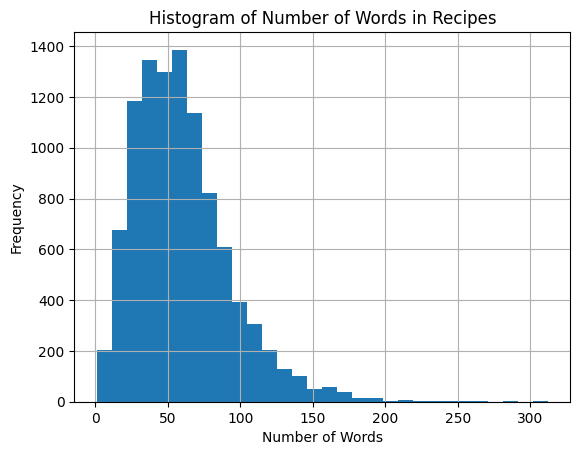

In [11]:
# histogram of the number of words in the recipes
df['num_words'] = df['ingredients'].apply(lambda x: len(x.split()))
df['num_words'].hist(bins=30)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Recipes')
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cooking_method  10000 non-null  object
 1   ingredients     10000 non-null  object
 2   Vegetarian      10000 non-null  int64 
 3   num_words       10000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 312.6+ KB


In [13]:
# get the cooking_method as a list of strings
cooking_methods = df['cooking_method'].values.tolist()
type(cooking_methods)

list

In [14]:
cooking_methods[0]

"['To bone turkey, place on a work surface, breast-side down. Slice skin along backbone from neck to tail. Cut and pull flesh and skin away from carcass. Cut flesh from saber-shaped bone near wing, and remove bone. Sever ball-and-socket joints so that they are separated from carcass but still attached to skin. Continue cutting breast meat away from bone until reaching the ridge of breastbone. Turn turkey around and repeat on other side. Pull gently to separate breastbone and carcass flesh. Cut off wing tip and middle section, leaving largest wing bone. Holding outside of wing bone, cut through tendons and scrape meat from bone. Pull out bone, using knife to free it. Holding inside end of leg bone, cut through tendons attaching the flesh to the bone. Use knife to scrape meat from bone, pushing it away from end of bone. Cut bone free of skin. Cut out any sinews still remaining on leg. Repeat on other side, then push leg and wing skin-side out. Butterfly breast so that meat completely cov

In [ ]:
# Load and preprocess your dataset
X = cooking_methods
y = df['Vegetarian'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data using BERT tokenizer
max_length = 200  # Adjust as needed
X_train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
X_val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length, return_tensors='pt')

# Define the model architecture
class CustomClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(CustomClassifier, self).__init__()
        self.bert = bert_model
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 16)
        self.fc2 = nn.Linear(16, 5)
        self.output = nn.Linear(5, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        x = torch.relu(self.fc1(pooled_output))
        x = torch.relu(self.fc2(x))
        logits = self.output(x)
        return logits

# Initialize the model, optimizer, and loss function
model = CustomClassifier(bert_model=bert_model, num_classes=2)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 15  # Adjust as needed
model.train()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(**X_train_encodings)
    loss = criterion(outputs.logits, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(**X_val_encodings)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    accuracy = (predicted_labels == y_val).float().mean().item()
    print(f'Validation Accuracy: {accuracy}')

In [12]:
# Tokenize and encode the recipe texts
max_length = 200  # Maximum sequence length for BERT
encoded_inputs = tokenizer(cooking_methods, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

In [13]:
# Define a simple classifier on top of BERT
class RecipeClassifier(nn.Module):
    def __init__(self, bert_model, num_classes, hidden_size=128, dropout_prob=0.1):
        super(RecipeClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [14]:
# Instantiate the recipe classifier model
num_classes = 2  # Vegetarian or non-vegetarian
recipe_classifier = RecipeClassifier(bert_model, num_classes)

# Perform classification
with torch.no_grad():
    logits = recipe_classifier(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
    probabilities = F.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)

In [15]:
# see data type of predicted_labels
type(predicted_labels)

torch.Tensor

In [16]:
# convert to numpy array
predicted_labels = predicted_labels.numpy()

# consider the column 'Vegetarian&Desserts' as the true labels
true_labels = df['Vegetarian&Desserts'].values
type(true_labels)

numpy.ndarray

In [17]:
# classification report
print(classification_report(true_labels, predicted_labels))

# confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       667
           1       0.00      0.00      0.00       333

    accuracy                           0.67      1000
   macro avg       0.33      0.50      0.40      1000
weighted avg       0.44      0.67      0.53      1000

[[667   0]
 [333   0]]


/Users/irene/VSCodeProjects/HLT-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irene/VSCodeProjects/HLT-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irene/VSCodeProjects/HLT-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

---

## Separate Embeddings and NN

### Prepare the dataset

In [4]:
df = pd.read_csv('./dataset/recipes_df_r.csv')
columns = ['cooking_method', 'ingredients', 'Vegetarian&Desserts']
df = df[columns]

In [5]:
#get the first 1000 elements
df1 = df[:1000]



10000

In [5]:
# get the cooking_method as a list of strings
cooking_methods = df['cooking_method'].values.tolist()
type(cooking_methods)

list

In [6]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

'''tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')'''

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

"tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')\nbert_model = BertModel.from_pretrained('bert-base-uncased')"

In [7]:
X = cooking_methods
y = df['Vegetarian&Desserts'].values

# Assuming 'X' contains your input data (cooking methods) and 'y' contains the target labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize input data using BERT tokenizer
max_length = 200  
X_train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Obtain BERT embeddings
train_outputs = bert_model(X_train_encodings)
val_outputs = bert_model(X_val_encodings)

In [8]:
# Extract BERT embeddings
train_embeddings = train_outputs.last_hidden_state
val_embeddings = val_outputs.last_hidden_state

In [9]:
train_embeddings.shape, val_embeddings.shape

(TensorShape([1600, 200, 768]), TensorShape([400, 200, 768]))

In [10]:
type(train_embeddings)

tensorflow.python.framework.ops.EagerTensor

In [11]:
(train_embeddings.numpy()).shape

(1600, 200, 768)

In [12]:
y_train.shape, y_val.shape

((1600,), (400,))

In [13]:
# reshape y_train and y_val
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

y_train.shape, y_val.shape

((1600, 1), (400, 1))

In [18]:
# Define feedforward neural network for classification using Keras
input_layer = Input(shape=(max_length, 768))  # BERT embedding size is 768
flatten_layer = Flatten()(input_layer)  # Flatten the BERT embeddings
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dropout_layer = Dropout(0.2)(dense_layer1)
dense_layer2 = Dense(64, activation='relu')(dropout_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer2)  # Assuming binary classification

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_embeddings.numpy(), y_train, epochs=10, batch_size=10, verbose=True)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7047 - loss: 0.6005
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8287 - loss: 0.3739
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9198 - loss: 0.2339
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9791 - loss: 0.1296
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9858 - loss: 0.0934
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9942 - loss: 0.0590
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9966 - loss: 0.0450
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9975 - loss: 0.0356
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 1.0000 - loss: 0.0210
Epoch 10/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9997 - loss: 0.0179


In [19]:
# predict the output and compare with y_val
predicted_labels = model.predict(val_embeddings.numpy())
predicted_labels = (predicted_labels > 0.5).astype(int)

# classification report
print(classification_report(y_val, predicted_labels))

# confusion matrix
cm = confusion_matrix(y_val, predicted_labels)
print(cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       251
           1       0.81      0.55      0.66       149

    accuracy                           0.79       400
   macro avg       0.79      0.74      0.75       400
weighted avg       0.79      0.79      0.77       400

[[232  19]
 [ 67  82]]


## Provare con 50% veg e 50% non veg

In [23]:
df = pd.read_csv('./dataset/recipes_df_r.csv')
columns = ['cooking_method', 'ingredients', 'Vegetarian&Desserts']
df = df[columns]

# take 1000 samples keeping same distribution of feature 'Vegetarian&Desserts'
df_v = df[df['Vegetarian&Desserts'] == 1].sample(n=1500)
df_nv = df[df['Vegetarian&Desserts'] == 0].sample(n=1500)
df = pd.concat([df_v, df_nv])
df = df.sample(frac=1)
df.head()

,cooking_method,ingredients,Vegetarian&Desserts
533,['For the bread pudding: Preheat the oven to 3...,"['Butter or cooking spray, for ramekins', '3 c...",1
7300,['Preheat a grill pan to medium-high heat. Dri...,"['1 pound flank steak', '1/4 cup olive oil, pl...",0
5380,['Preheat the oven to 325 degrees F. Lightly b...,"['1/2 pound (2 sticks) unsalted butter, plus e...",1
4691,"['Preheat oven to 350 degrees F.', 'For the ca...","['3 tablespoons butter', '1 tablespoon minced ...",0
4197,"['For the rice: Place the rice, 3 cups water, ...","['1 1/2 cups long-grain white rice, rinsed', '...",1


In [24]:
# get the cooking_method as a list of strings
cooking_methods = df['cooking_method'].values.tolist()
type(cooking_methods)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

'''tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')'''
X = cooking_methods
y = df['Vegetarian&Desserts'].values

# Assuming 'X' contains your input data (cooking methods) and 'y' contains the target labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [25]:
# Tokenize input data using BERT tokenizer
max_length = 200  
X_train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Obtain BERT embeddings
train_outputs = bert_model(X_train_encodings)
val_outputs = bert_model(X_val_encodings)

# Extract BERT embeddings
train_embeddings = train_outputs.last_hidden_state
val_embeddings = val_outputs.last_hidden_state
train_embeddings.shape, val_embeddings.shape

(TensorShape([2400, 200, 768]), TensorShape([600, 200, 768]))

In [51]:
# reshape y_train and y_val
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Define feedforward neural network for classification using Keras
input_layer = Input(shape=(max_length, 768))  # BERT embedding size is 768
flatten_layer = Flatten()(input_layer)  # Flatten the BERT embeddings
dense_layer1 = Dense(64, activation='relu')(flatten_layer)
dropout_layer = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(32, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(0.2)(dense_layer2)
dense_layer3 = Dense(16, activation='relu')(dropout_layer2)
dense_layer4 = Dense(8, activation='relu')(dense_layer3)
output_layer = Dense(1, activation='sigmoid')(dense_layer4)  # Assuming binary classification

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_embeddings.numpy(), y_train, epochs=30, batch_size=32, verbose=True)
# predict the output and compare with y_val
predicted_labels = model.predict(val_embeddings.numpy())
predicted_labels = (predicted_labels > 0.5).astype(int)

# classification report
print(classification_report(y_val, predicted_labels))

# confusion matrix
cm = confusion_matrix(y_val, predicted_labels)
print(cm)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5146 - loss: 0.6968
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5791 - loss: 0.6759
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6571 - loss: 0.6279
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7152 - loss: 0.5592
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7675 - loss: 0.5025
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8053 - loss: 0.4781
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8154 - loss: 0.4486
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8359 - loss: 0.4120
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8404 - loss: 0.3937
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8795 - loss: 0.3477
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8834 - loss: 0.3212
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: